In [1]:
import toolbox as tbx
import matplotlib.pyplot as plt
import os
import datetime
import numpy as np

%matplotlib inline

In [2]:
plot_directory = os.path.abspath('./plots')
if not os.path.isdir(plot_directory):
    os.makedirs(plot_directory)

In [3]:
# Base directory for the ENA data
ENA_data_dir = os.path.join(os.getenv("HOME"), 'Research/data/ENA')

# Individual directories for the ENA datastreams
ENA_ccn_directory = os.path.join(ENA_data_dir, 'ccn')
ENA_met_directory = os.path.join(ENA_data_dir, 'met')

# File locations of cached HDF5 files
ENA_ccn_h5file = os.path.join(ENA_data_dir, 'ENA_CCN.h5')
ENA_met_h5file = os.path.join(ENA_data_dir, 'ENA_MET.h5')

In [4]:
# Base directory for the AMF (GRW) data
AMF_data_dir = os.path.join(os.getenv("HOME"), 'Research/data/GRW')

# Individual directories for the AMF datastreams
AMF_ccn_directory = os.path.join(AMF_data_dir, 'ccn/AOSCCN')
AMF_met_directory = os.path.join(AMF_data_dir, 'sfcmet')

# File locations of cached HDF5 files
AMF_ccn_h5file = os.path.join(AMF_data_dir, 'AMF_CCN.h5')
AMF_met_h5file = os.path.join(AMF_data_dir, 'AMF_MET.h5')

In [5]:
def process_ccn(ccn_directory, ccn_h5file, force_rewrite=False):
    if os.path.isfile(ccn_h5file) and not force_rewrite:
        ccn = tbx.fileIO.HDF.read_file(ccn_h5file).data
    else:
        CCN = tbx.fileIO.NetCDFFolder(ccn_directory)
        CCN.summary()
        ccn = CCN.process(varlist=('N_CCN', 'CCN_ss_set', 'CCN_supersaturation_set_point'),
                          mapping={'N_CCN': 'CCN', 'CCN_ss_set': 'SS',
                                   'CCN_supersaturation_set_point': 'SS'},
                         savefile=ccn_h5file)
    return ccn

def process_met(met_directory, met_h5file, force_rewrite=False):
    if os.path.isfile(met_h5file) and not force_rewrite:
        met = tbx.fileIO.HDF.read_file(met_h5file).data
    else:
        MET = tbx.fileIO.NetCDFFolder(met_directory)
        MET.summary()
        met = MET.process(varlist=('atmos_pressure', 'temp_mean', 
                                   'wdir_vec_mean', 'wspd_vec_mean',
                                   'wind_dir_vec_avg', 'wind_spd_vec_avg'),
                          mapping={'atmos_pressure': 'pressure',
                                   'temp_mean': 'temperature',
                                   'wdir_vec_mean': 'wdir',
                                   'wspd_vec_mean': 'wspd',
                                   'wind_dir_vec_avg': 'wdir',
                                   'wind_spd_vec_avg': 'wspd'},
                          savefile=met_h5file)
    
    return met

In [65]:
ENA_CCN = process_ccn(ENA_ccn_directory, ENA_ccn_h5file)
ENA_MET = process_met(ENA_met_directory, ENA_met_h5file)

#AMF_CCN = process_ccn(AMF_ccn_directory, AMF_ccn_h5file)
AMF_MET = process_met(AMF_met_directory, AMF_met_h5file)

In [7]:
ENA_MET_MONTHLY = ENA_MET.groupby(lambda x: x.month)
AMF_MET_MONTHLY = AMF_MET.groupby(lambda x: x.month)

In [8]:
def seasons(x):
    if x in (12, 1, 2): return 'DJF'
    elif x in (3, 4, 5): return 'MAM'
    elif x in (6, 7, 8): return 'JJA'
    elif x in (9, 10, 11): return 'SON'

def season_string(x): 
    if x == 'DJF': return 'December-January-February'
    elif x == 'MAM': return 'March-April-May'
    elif x == 'JJA': return 'June-July-August'
    elif x == 'SON': return 'September-October-November'

ENA_MET_SEASONAL = ENA_MET.groupby(lambda x: seasons(x.month))
AMF_MET_SEASONAL = AMF_MET.groupby(lambda x: seasons(x.month))

In [9]:
def paired_rose(LEFT, RIGHT, **kwargs):
    
    left_title = kwargs.pop('left_title', None)
    right_title = kwargs.pop('right_title', None)

    fig = plt.figure(figsize=(14, 7))
    wspd_bins = [0, 2, 4, 6, 8, 10, 15]

    rect = rect=[0.05, 0.1, 0.4, 0.8]
    fig, ax = tbx.plotting.windrose(direction=LEFT['wdir'], 
                                    speed=LEFT['wspd'], 
                                    fig=fig, rect=rect, 
                                    normed=True, bins=wspd_bins,
                                    legend=False,
                                    nsector=32)
    ax.set_yticklabels('')
    if left_title is not None:
        ax.set_title(left_title, y=1.08)

    rect = [0.55, 0.1, 0.4, 0.8]
    fig, bx = tbx.plotting.windrose(direction=RIGHT['wdir'], 
                                    speed=RIGHT['wspd'], 
                                    fig=fig, rect=rect, 
                                    normed=True, bins=wspd_bins,
                                    legend=False,
                                    nsector=32)
    bx.set_yticklabels('')
    if right_title is not None:
        bx.set_title(right_title, y=1.08)

    bx.legend(fontsize=9, title="Wind Speed Bins (m/s)",
                  bbox_to_anchor=[0.5, 0.1], bbox_transform=fig.transFigure,
                  loc='lower center', frameon=False)
    
    return fig, ax, bx

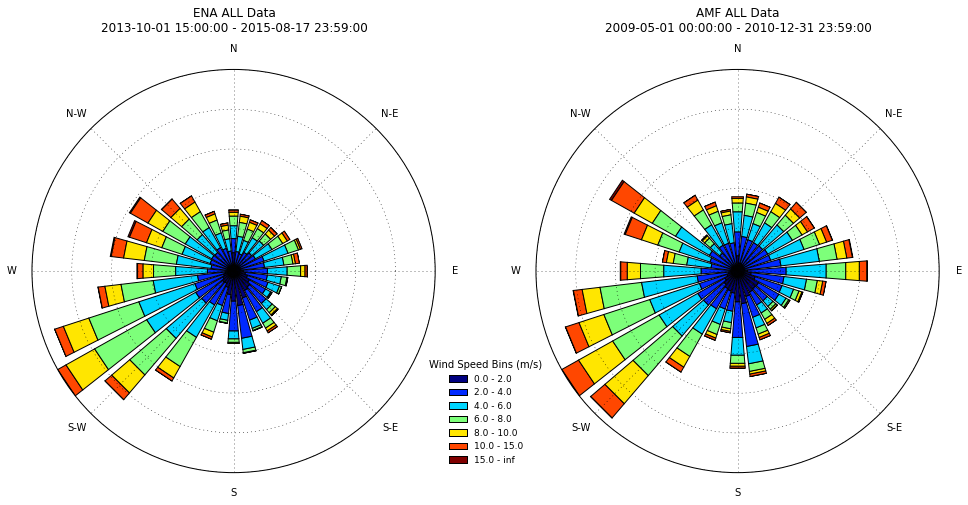

In [10]:
fig, ax, bx = paired_rose(ENA_MET, AMF_MET, 
                          left_title='ENA ALL Data\n{} - {}'.format(ENA_MET.index[0], ENA_MET.index[-1]), 
                          right_title='AMF ALL Data\n{} - {}'.format(AMF_MET.index[0], AMF_MET.index[-1]))
fig.savefig(os.path.join(plot_directory, 'all_data.png'), dpi=300)

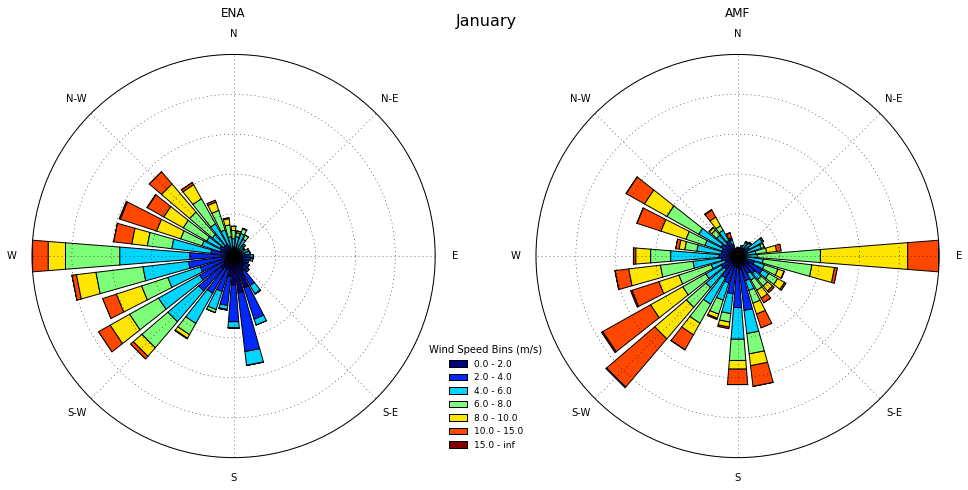

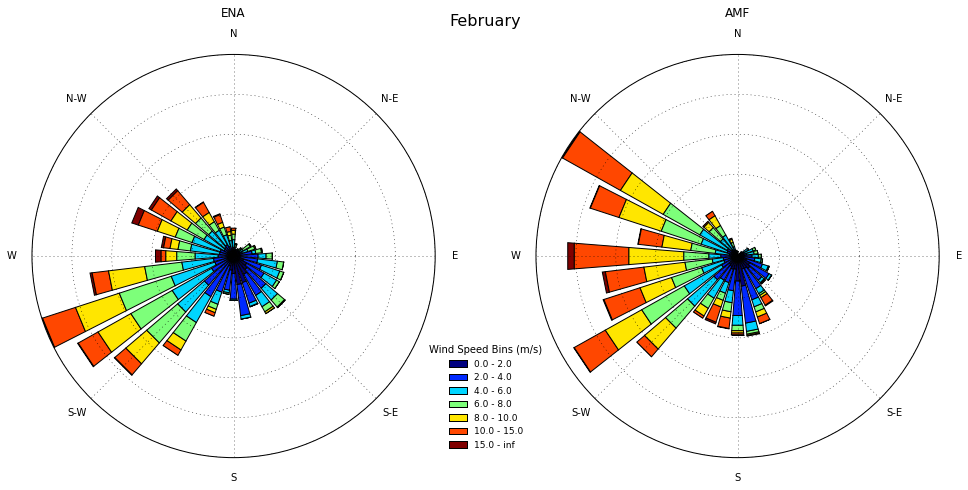

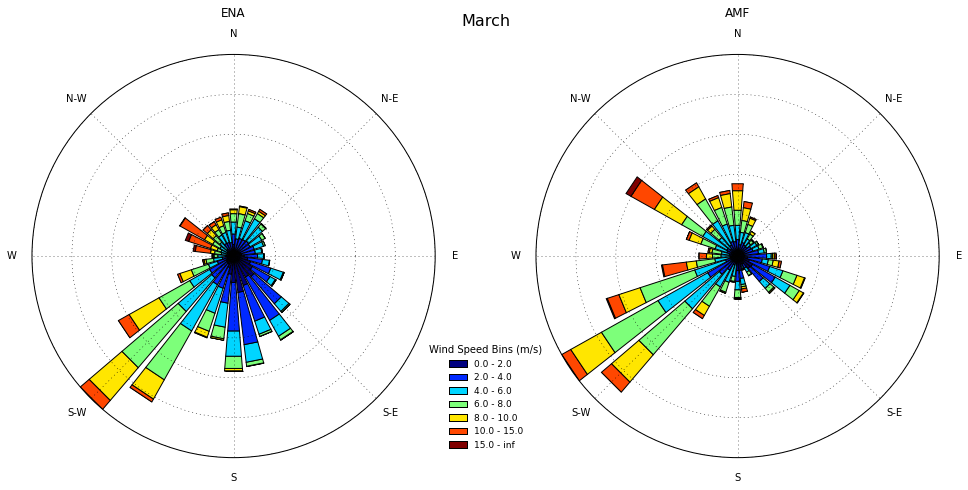

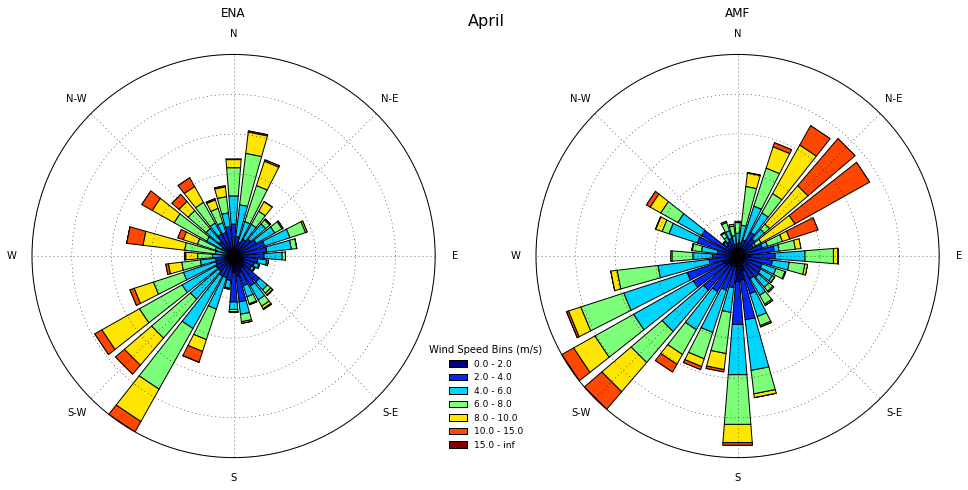

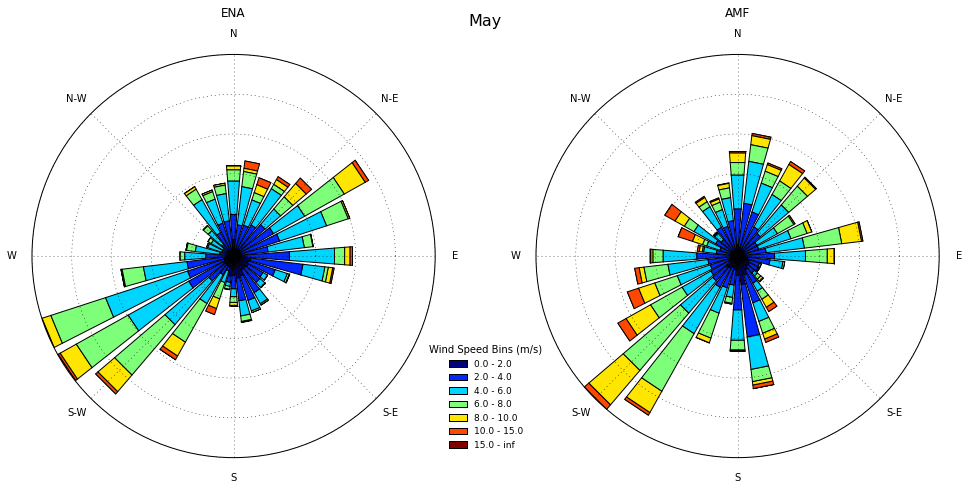

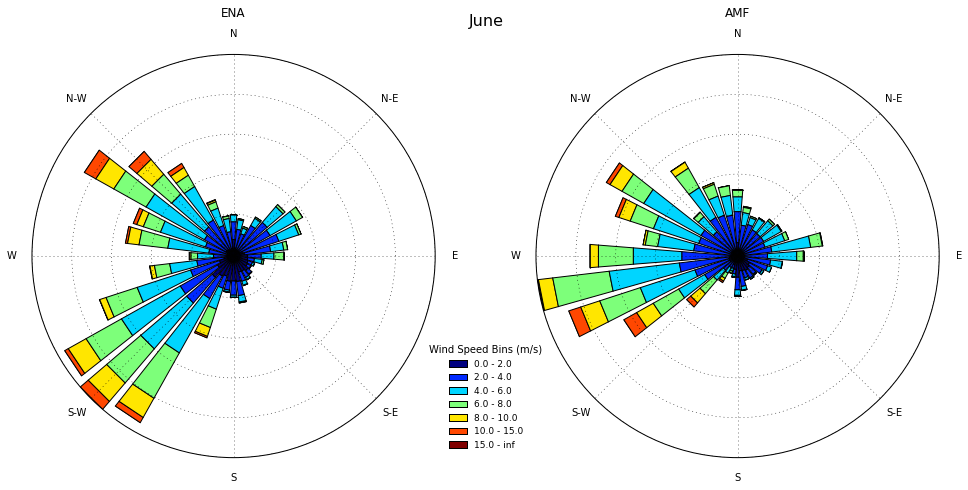

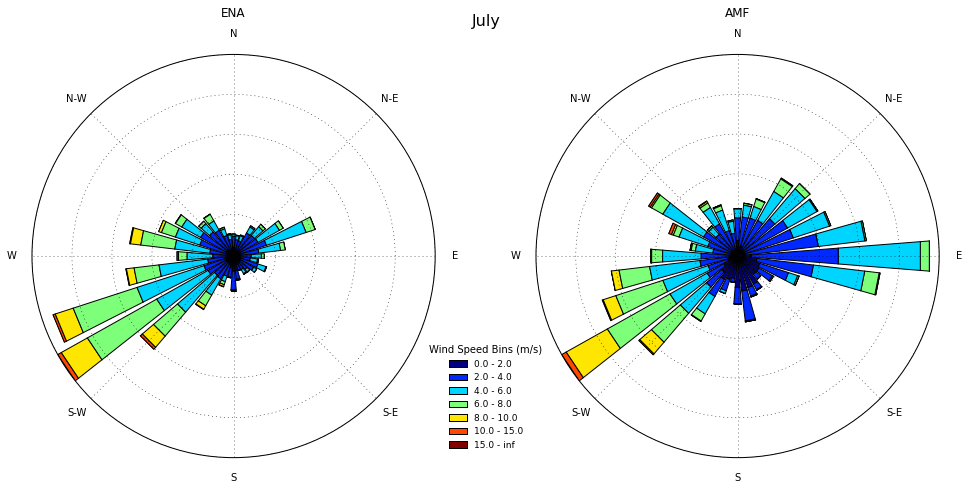

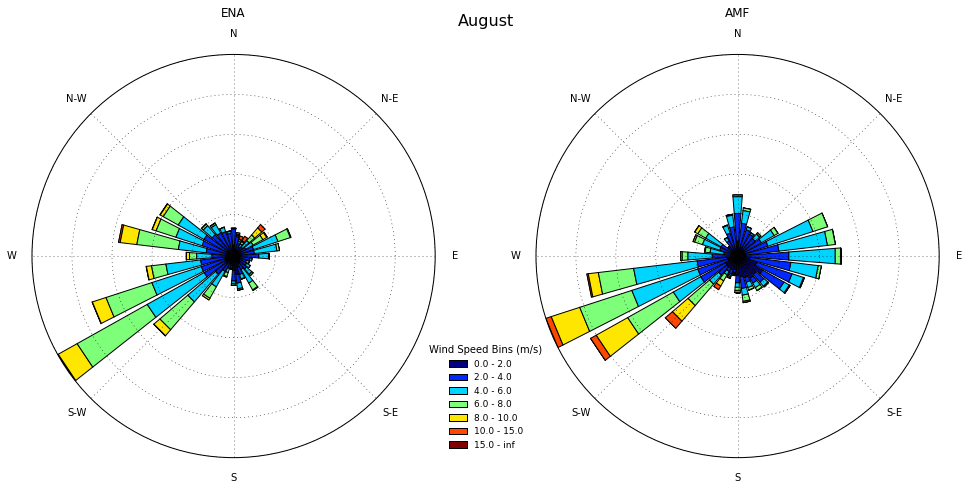

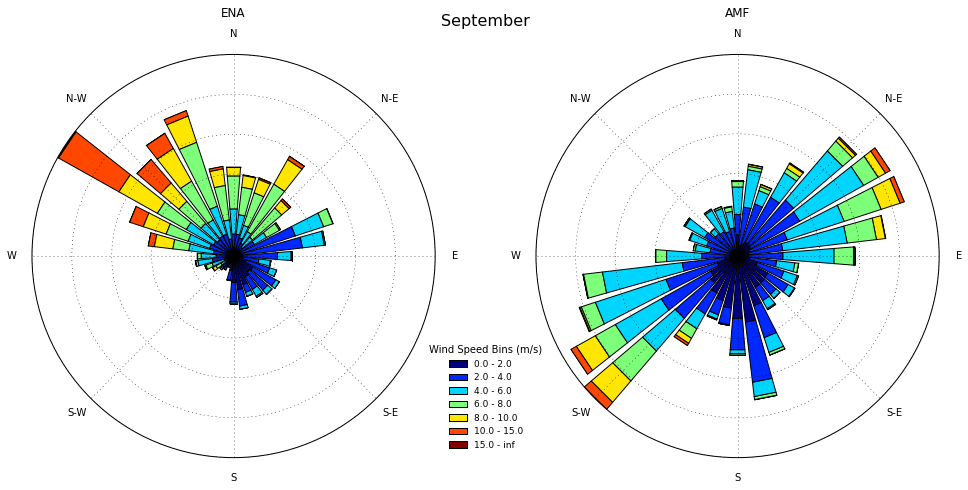

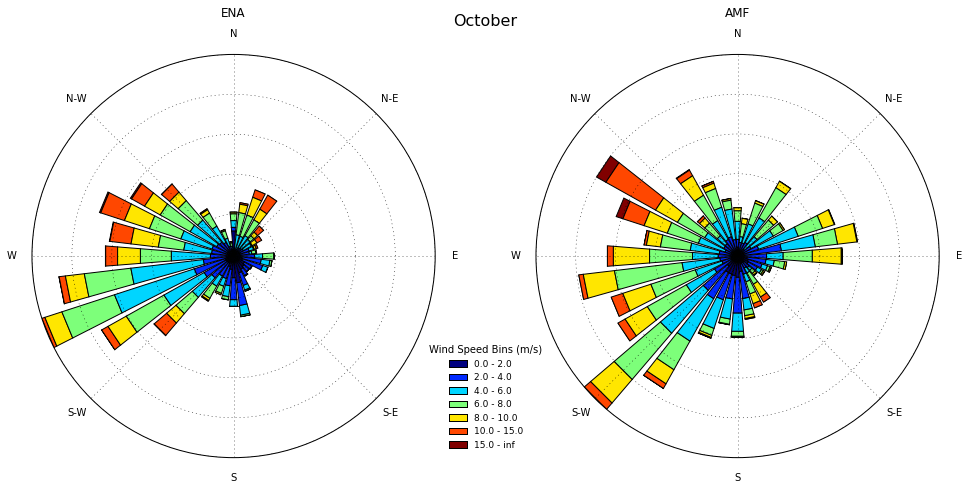

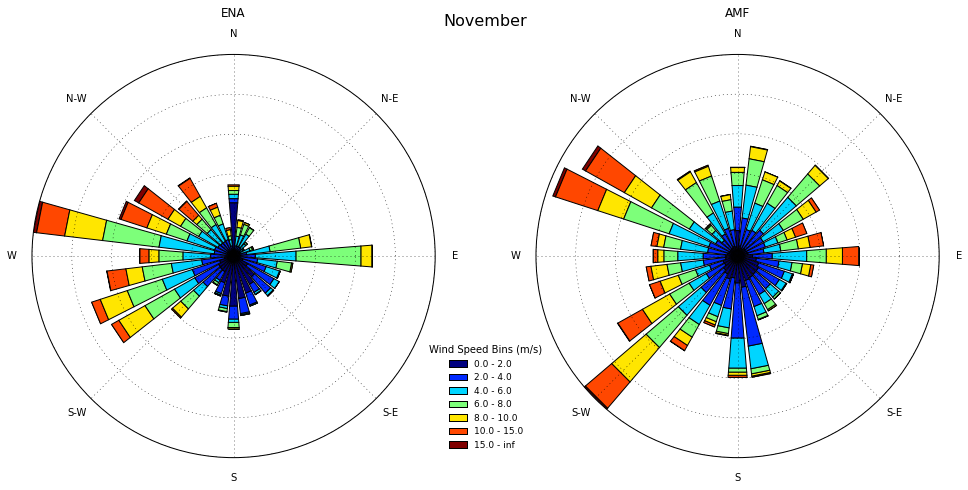

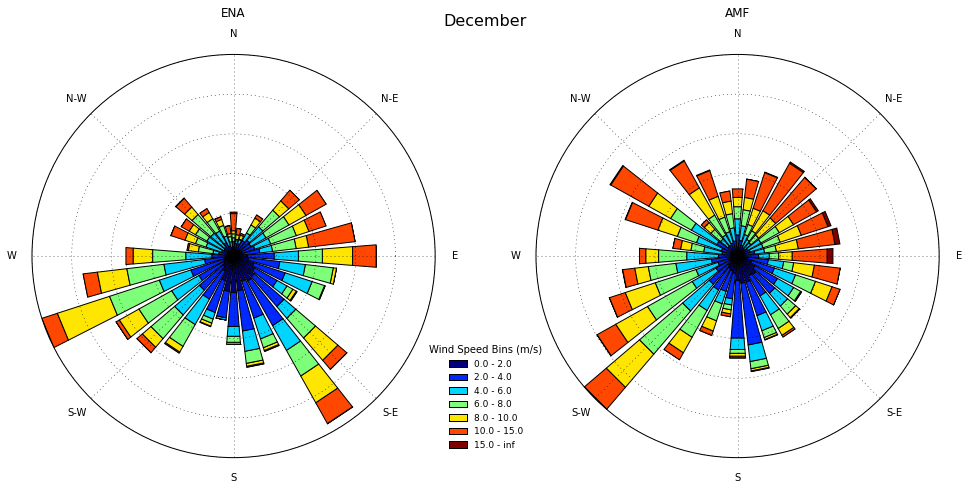

In [11]:
for i in np.arange(12)+1:
    LEFT = ENA_MET_MONTHLY.get_group(i)
    RIGHT = AMF_MET_MONTHLY.get_group(i)
    MONTH = datetime.date(2000, i, 1).strftime('%B')
    fig, ax, bx = paired_rose(LEFT, RIGHT, 
                              left_title='ENA', right_title='AMF')
    fig.suptitle(MONTH, fontsize=16)
    
    fig.savefig(os.path.join(plot_directory, '{}.png'.format(MONTH)), dpi=300)

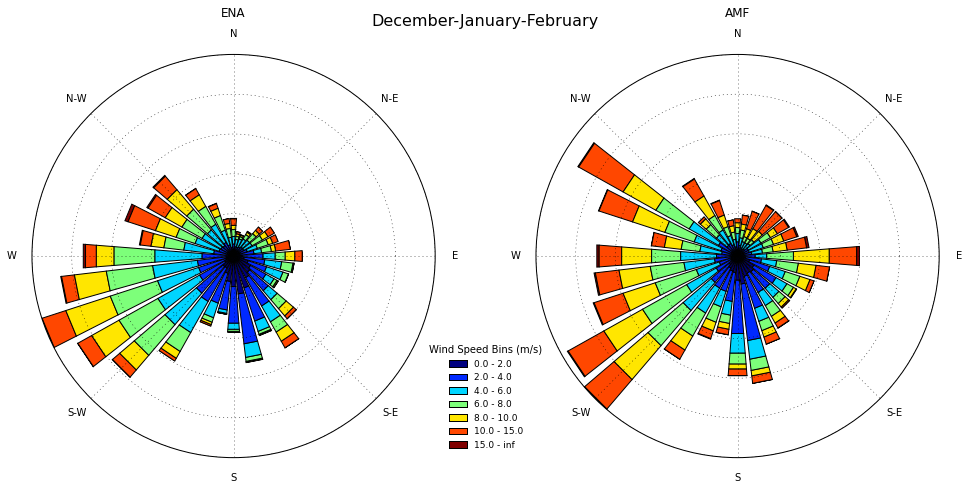

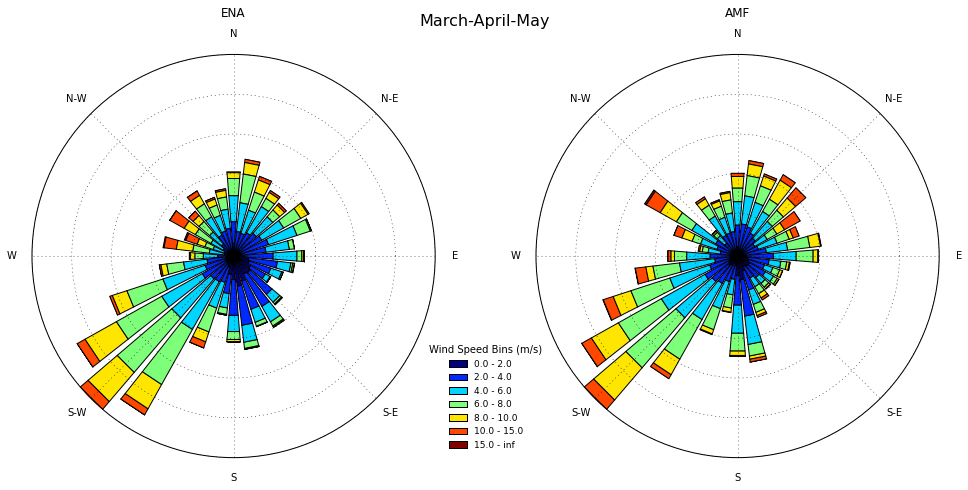

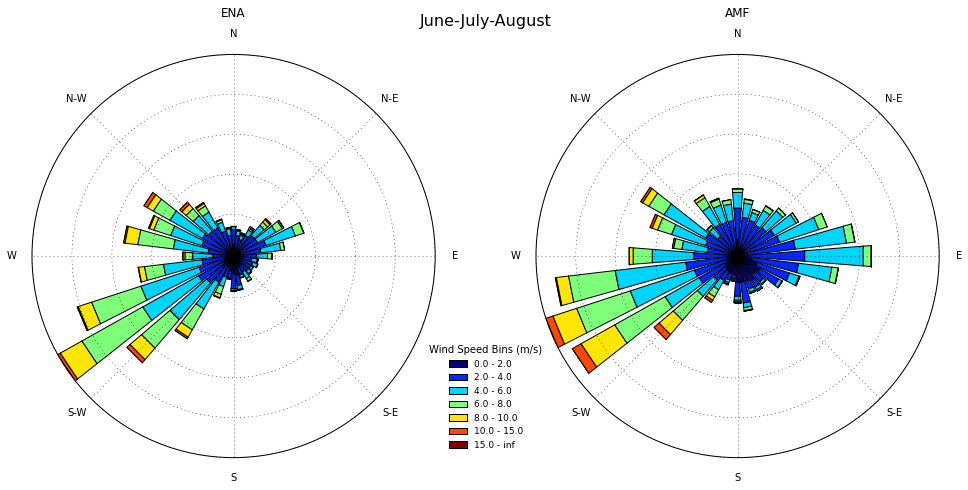

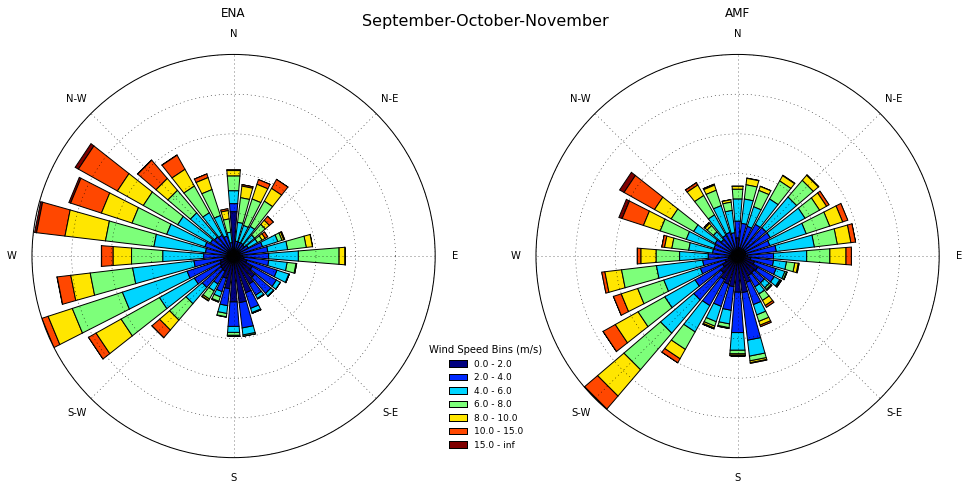

In [12]:
for i in ('DJF', 'MAM', 'JJA', 'SON'):
    LEFT = ENA_MET_SEASONAL.get_group(i)
    RIGHT = AMF_MET_SEASONAL.get_group(i)
    
    fig, ax, bx = paired_rose(LEFT, RIGHT, 
                              left_title='ENA', right_title='AMF')
    fig.suptitle(season_string(i), fontsize=16)
    
    fig.savefig(os.path.join(plot_directory, '{}.png'.format(i)), dpi=300)

In [39]:
ENA = ENA_CCN.resample('1Min', how='mean').join(ENA_MET).dropna(how='any')
#AMF = AMF_CCN.resample('1Min', how='mean').join(AMF_MET).dropna(how='any')

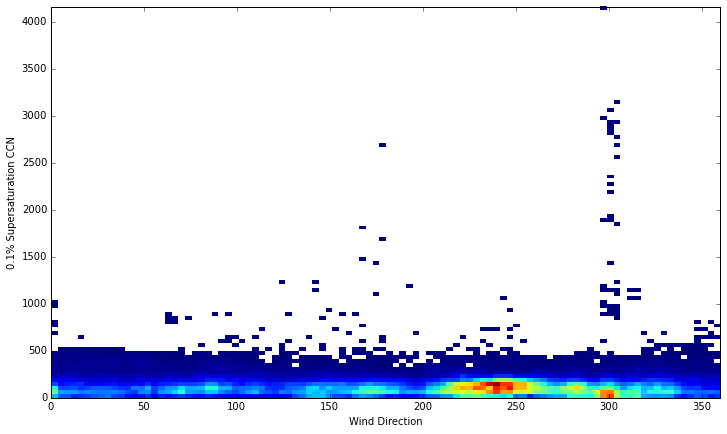

In [63]:
fig, ax = plt.subplots(figsize=(12, 7))
#rng = [[0, 360], [0, 2500]]
rng=None

sample = ENA[(ENA.SS > 0.09) & (ENA.SS < .11)]
h0 = ax.hist2d(sample['wdir'].astype(float), sample['CCN'].astype(float), 
                  bins=100, cmin=1, range=rng)
ax.set_ylabel('0.1% Supersaturation CCN')
ax.set_xlabel('Wind Direction')

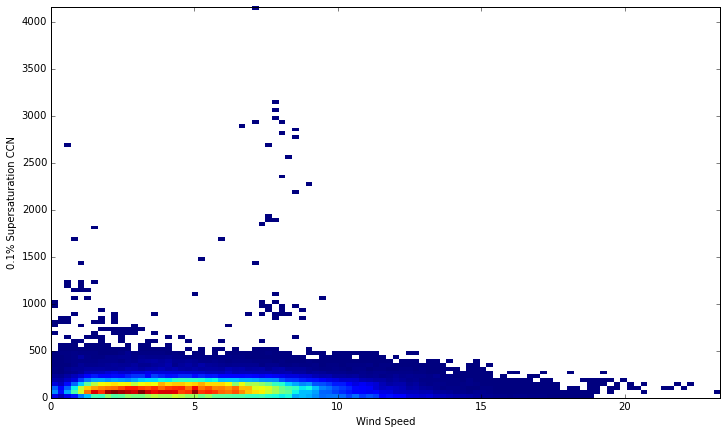

In [64]:
fig, ax = plt.subplots(figsize=(12, 7))
#rng = [[0, 15], [0, 2500]]
rng = None

sample = ENA[(ENA.SS > 0.09) & (ENA.SS < .11)]
h0 = ax.hist2d(sample['wspd'].astype(float), sample['CCN'].astype(float), 
                  bins=100, cmin=1, range=rng)
ax.set_ylabel('0.1% Supersaturation CCN')
ax.set_xlabel('Wind Speed')